# CSCA 5642 Introduction to Deep Learning Final Project

## 1. Abstract
This project focuses on the automatic classification of plant diseases, which is a crucial task in agriculture. Accurate and rapid identification of plant diseases enables farmers to take timely action, prevent disease spread, increase crop yield, reduce economic losses, and promote sustainable agricultural practices. However, due to the diversity of plant disease types and the class imbalance in image datasets, traditional classification methods often struggle to achieve ideal results. To address these challenges, we employed multiple deep learning models (ResNet50, VGG16, and GoogLeNet) for the classification task and compared their performance in a multi-class setting. During the model evaluation phase, we explored the best-performing deep learning framework for this task by comparing four evaluation metrics: Test Accuracy, Precision, Recall, and F1-score.
Our project aims to explore and develop a deep learning framework suitable for the automatic classification of plant diseases.

## 2. Data Detail

The dataset used in this study comes from the Kaggle competition’s PlantVillage dataset (https://www.kaggle.com/datasets/mohitsingh1804/plantvillage/data), which includes a total of 38 plant categories. This dataset contains 54,305 images of diseased and healthy plant leaves collected under controlled conditions (PlantVillage dataset). These images cover 14 crop species, including apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soybean, squash, strawberry, and tomato. It includes images of 17 primary diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycetes), 2 viral diseases, and 1 disease caused by mites. Additionally, 12 of these crop species have images of healthy leaves that show no apparent signs of disease. The primary dimensions of the images in the dataset are 256×256.

## 3. Data Processing and Analysis

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import Counter
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set the path
train_dir = 'PlantVillage/train'
val_dir = 'PlantVillage/val'
test_dir = 'PlantVillage/test'
batch_size = 32

### 3.1 Data Augmentation (Data Cleaning)

Consider the high demand for diverse and abundant data in the field of image detection, we have introduced a series of data augmentation techniques to enhance the robustness and generalization capability of our models. These techniques include random cropping, which helps simulate variations in object positioning; random rotation, which accounts for different viewing angles; and color jitter, which mimics changes in lighting conditions and color variations in real-world scenarios. Additionally, Gaussian blur is applied to introduce subtle distortions, improving the model’s ability to handle image noise and imperfections. Together, these operations significantly expand the variability of the training dataset, reducing the risk of overfitting and enabling the model to better adapt to unseen data during testing. By leveraging these augmentations, our approach ensures improved performance and reliability in practical applications.

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
img_height = 224
img_width = 224
# Define the transformations for data pre-processing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(img_height, img_width)),  
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(degrees=30), 
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Apply random affine transformation
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),  # Apply perspective distortions
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Adding Gaussian blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_height, img_width)),  # Resize to fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with the same stats
])

test_transform = transforms.Compose([
    transforms.Resize(size=(img_height, img_width)),  # Resize to fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with the same stats
])

# Create the train, val and test
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

# Load Data
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### 3.2 Exploratory Data Analysis (EDA)

To gain a deeper understanding of the dataset's distribution and characteristics, and to provide a foundation for subsequent model development and optimization, we aim to conduct an in-depth analysis of the dataset through EDA.

Class distribution in the training dataset:
Apple___Apple_scab: 429 images
Apple___Black_rot: 421 images
Apple___Cedar_apple_rust: 187 images
Apple___healthy: 1119 images
Blueberry___healthy: 1022 images
Cherry_(including_sour)___Powdery_mildew: 716 images
Cherry_(including_sour)___healthy: 582 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 349 images
Corn_(maize)___Common_rust_: 811 images
Corn_(maize)___Northern_Leaf_Blight: 670 images
Corn_(maize)___healthy: 790 images
Grape___Black_rot: 803 images
Grape___Esca_(Black_Measles): 941 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 732 images
Grape___healthy: 289 images
Orange___Haunglongbing_(Citrus_greening): 3745 images
Peach___Bacterial_spot: 1563 images
Peach___healthy: 245 images
Pepper,_bell___Bacterial_spot: 678 images
Pepper,_bell___healthy: 1006 images
Potato___Early_blight: 680 images
Potato___Late_blight: 680 images
Potato___healthy: 103 images
Raspberry___healthy: 253 images
Soybean___healthy: 3462 images
Sq

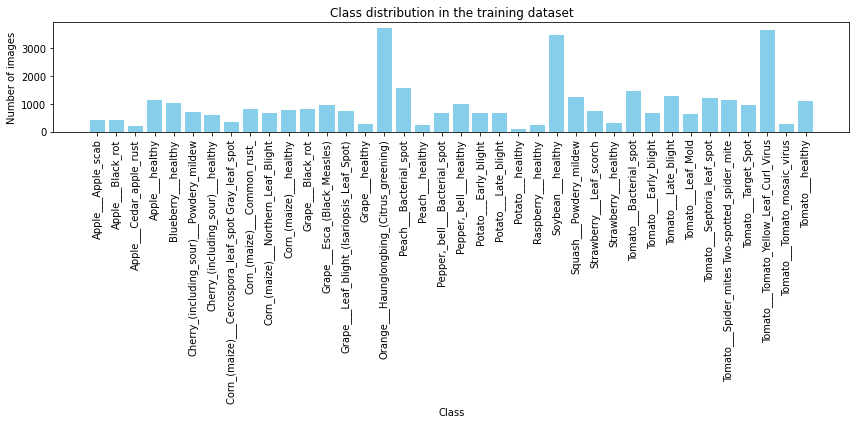

In [7]:
class_names = sorted(os.listdir(train_dir))
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]

total_count = sum(class_counts)
class_weights = [total_count / (len(class_names) * count) for count in class_counts]

print('Class distribution in the training dataset:')
for class_name, count in zip(class_names, class_counts):
    print(f'{class_name}: {count} images')

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class distribution in the training dataset')
plt.tight_layout() 
plt.show()

From the chart, it can be observed that the bar heights vary significantly across different categories, indicating that certain categories have a larger number of samples in the dataset, while others have relatively fewer samples. This class imbalance can affect the model's performance, leading to poorer predictions for categories with fewer samples. This is also why we applied data augmentation methods in the previous section to mitigate the impact of class imbalance as much as possible.

Next, the brightness and contrast of images in each category were analyzed. This helps to identify differences in visual characteristics among categories based on the distribution of brightness and contrast. For example, it allows us to determine whether certain categories are generally darker, brighter, or have lower contrast. This, in turn, enables a more comprehensive understanding of the overall structure and characteristics of the dataset.

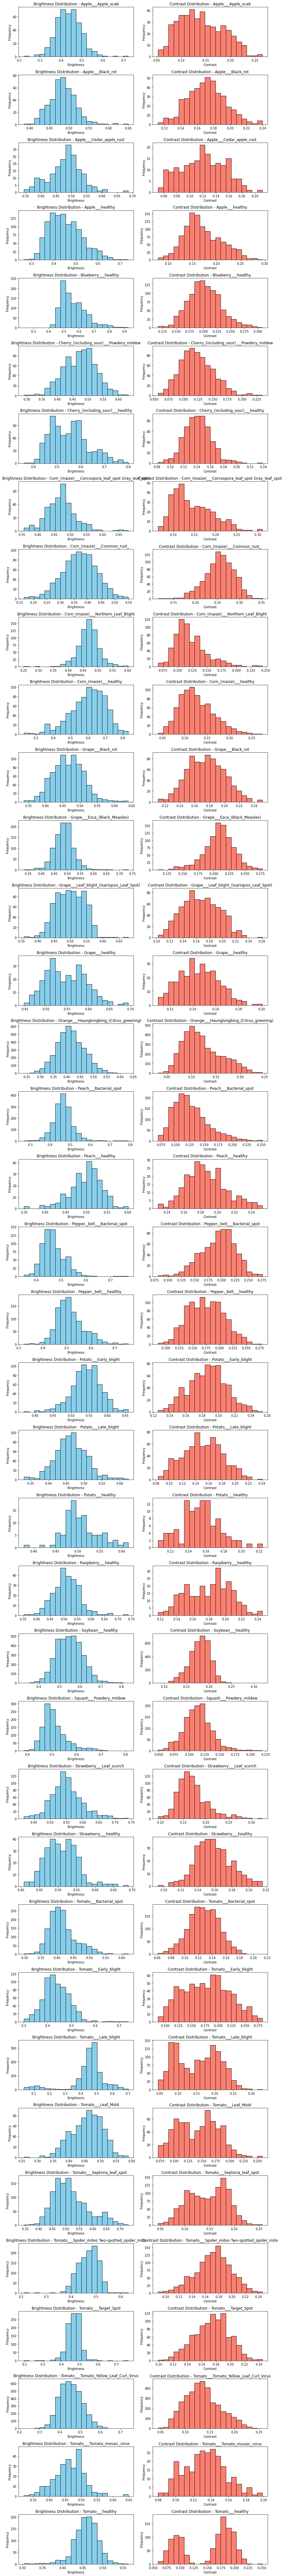

In [8]:
from skimage import color
from PIL import Image

# Initialize dictionaries to store brightness and contrast for each class
brightness_dict = {class_name: [] for class_name in class_names}
contrast_dict = {class_name: [] for class_name in class_names}

# Calculate brightness and contrast for all images in each class
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert("RGB")  # Convert to RGB to ensure 3 channels
        img_gray = color.rgb2gray(np.array(img))   # Convert to grayscale
        
        # Brightness is the mean pixel value
        brightness = img_gray.mean()
        brightness_dict[class_name].append(brightness)
        
        # Contrast is the standard deviation of pixel values
        contrast = img_gray.std()
        contrast_dict[class_name].append(contrast)

# Plot brightness and contrast distributions for each class
fig, axes = plt.subplots(len(class_names), 2, figsize=(12, len(class_names) * 3))

for i, class_name in enumerate(class_names):
    axes[i, 0].hist(brightness_dict[class_name], bins=20, color="skyblue", edgecolor="black")
    axes[i, 0].set_title(f"Brightness Distribution - {class_name}")
    axes[i, 0].set_xlabel("Brightness")
    axes[i, 0].set_ylabel("Frequency")

    # Plot contrast distribution
    axes[i, 1].hist(contrast_dict[class_name], bins=20, color="salmon", edgecolor="black")
    axes[i, 1].set_title(f"Contrast Distribution - {class_name}")
    axes[i, 1].set_xlabel("Contrast")
    axes[i, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The results indicate that some categories have narrower (more concentrated) brightness distributions, suggesting that the image brightness is more consistent within these categories. On the other hand, some categories exhibit wider distributions, indicating greater variations in brightness. Additionally, certain categories show higher contrast distributions, which suggests greater differences between light and dark areas in the images, potentially containing more details. Categories with lower contrast distributions imply that the images are relatively flat, with less noticeable variations in brightness, which could pose challenges for feature extraction.

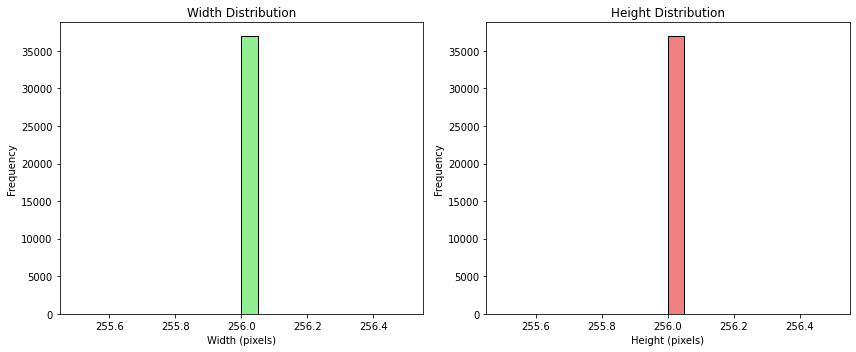

In [9]:
# Calculate image dimensions
widths = []
heights = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# Plot image dimension distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color="lightgreen", edgecolor="black")
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color="lightcoral", edgecolor="black")
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [10]:
num_workers = 16
sample_weights = [class_weights[label] for _, label in train_dataset]

# Create a WeightedRandomSampler to sample the training data with replacement
sampler = WeightedRandomSampler(sample_weights, len(train_dataset), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

#train dataset
augmented_train_dataset = ImageFolder(train_dir, transform=train_transform)

#Combine the original and augmented train datasets
combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_train_dataset])
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

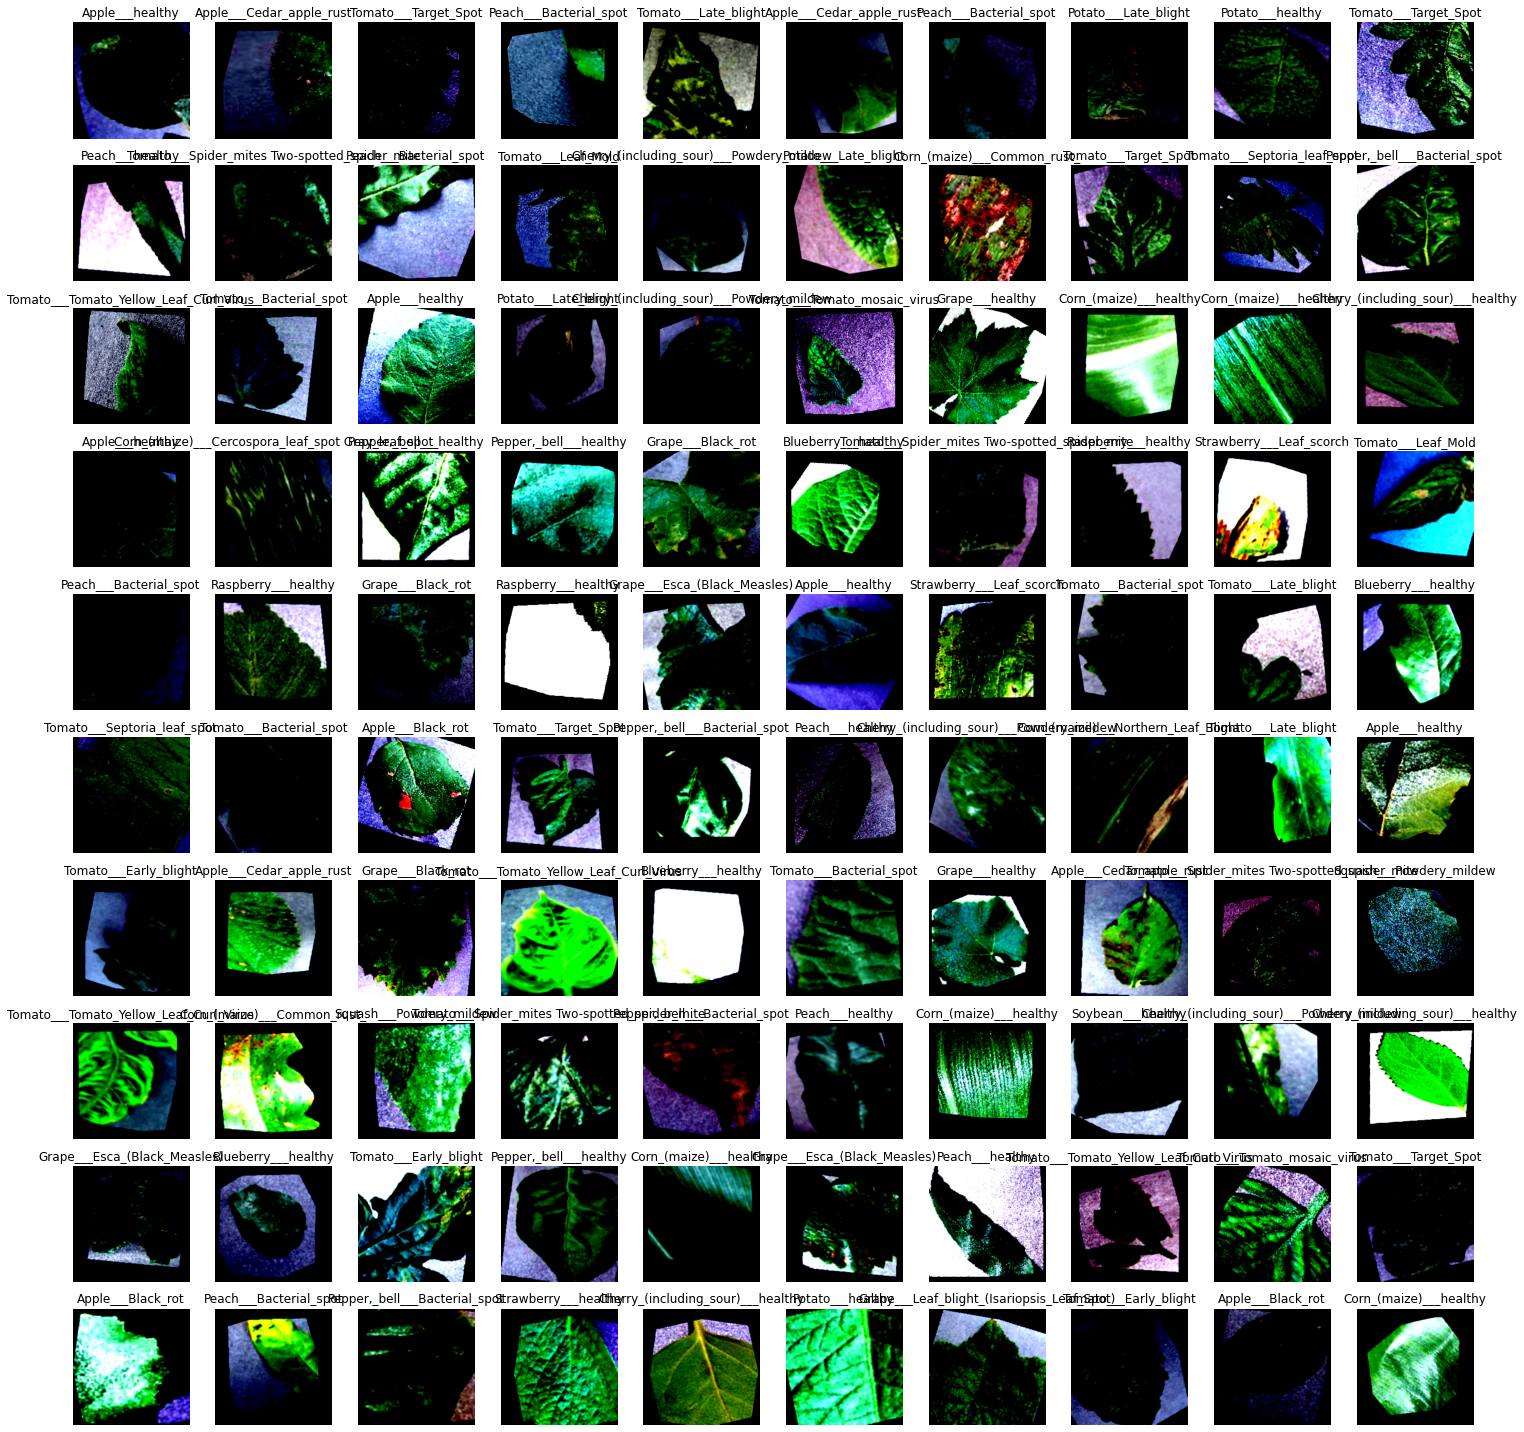

In [11]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20)) 
axs = axs.flatten()

for i, (images, labels) in enumerate(train_loader):
    image = np.clip(np.transpose(images[0], (1, 2, 0)), 0, 1)
    axs[i].imshow(image)  
    axs[i].set_title(class_names[labels[0]])  
    axs[i].axis('off')  

    if i == 99:  
        break

plt.tight_layout()  
plt.show()


## 4. Model

In this section, we introduced several deep learning models, including CNN, ResNet-50, and VGG-16. Among them, ResNet-50 and VGG-16 are models that were not covered in the classroom.
I visualized the results of multiple evaluation metrics for these three models, including Accuracy, Precision, Recall, and F1-Score, using histograms.

### 4.1 CNN

In [13]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class CNN(nn.Module):
    def __init__(self, num_classes=38): 
        super(CNN, self).__init__()
        self.model = models.resnet18(pretrained=True) 
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
num_classes = 38
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
model = CNN(num_classes=num_classes)  
model = model.to(device)  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        # Train phase
        model.train()
        running_loss = 0.0 #Because the loss function are floating-point number
        correct_predictions = 0
        total_predictions = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward pass and optimiz
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

            # Every 100 iter.
            if i % 100 == 0:  
                batch_loss = running_loss / (i + 1)
                batch_acc = correct_predictions.double() / total_predictions
                print(f"Iteration {i}: Loss: {batch_loss:.4f} Acc: {batch_acc:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        model.eval()  
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():  
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
                total_predictions += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_predictions.double() / total_predictions

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    print("Training complete.")
    model.load_state_dict(best_model_wts)  # Load the best model weights
    return model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train
trained_model = train_model(model, combined_train_loader, val_loader, criterion, optimizer, num_epochs=10)
# Save model
torch.save(trained_model.state_dict(), 'cnn_best_model.pth')

Epoch 0/9
----------
Iteration 0: Loss: 124.7354 Acc: 0.0000
Iteration 100: Loss: 64.6796 Acc: 0.4926
Iteration 200: Loss: 49.0436 Acc: 0.6099
Iteration 300: Loss: 41.0488 Acc: 0.6681
Iteration 400: Loss: 36.2653 Acc: 0.7022
Iteration 500: Loss: 32.8446 Acc: 0.7262
Iteration 600: Loss: 30.2920 Acc: 0.7456
Iteration 700: Loss: 28.1153 Acc: 0.7630
Iteration 800: Loss: 26.4546 Acc: 0.7759
Iteration 900: Loss: 25.0256 Acc: 0.7862
Iteration 1000: Loss: 23.9390 Acc: 0.7945
Iteration 1100: Loss: 22.9590 Acc: 0.8016
Iteration 1200: Loss: 22.0729 Acc: 0.8084
Iteration 1300: Loss: 21.2675 Acc: 0.8148
Iteration 1400: Loss: 20.5747 Acc: 0.8204
Iteration 1500: Loss: 19.9249 Acc: 0.8257
Iteration 1600: Loss: 19.3834 Acc: 0.8298
Iteration 1700: Loss: 18.8454 Acc: 0.8340
Iteration 1800: Loss: 18.3701 Acc: 0.8377
Iteration 1900: Loss: 17.9211 Acc: 0.8416
Iteration 2000: Loss: 17.5647 Acc: 0.8444
Iteration 2100: Loss: 17.1853 Acc: 0.8474
Iteration 2200: Loss: 16.8654 Acc: 0.8499
Iteration 2300: Loss: 16

Test the model

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    # Accuracy
    correct_predictions = sum(np.array(all_preds) == np.array(all_labels))
    total_predictions = len(all_labels)
    test_acc = correct_predictions / total_predictions

    # other metrics
    precision = precision_score(all_labels, all_preds, average='macro')  
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Output metrics
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

# Test
test_model(trained_model, test_loader)


Test Accuracy: 0.9894
Precision: 0.9873
Recall: 0.9799
F1-score: 0.9810
Confusion Matrix:
[[ 70   1   0 ...   0   0   0]
 [  0  75   0 ...   0   0   0]
 [  0   0  33 ...   0   0   0]
 ...
 [  0   0   0 ... 642   0   0]
 [  0   0   0 ...   0  44   0]
 [  0   0   0 ...   0   0 190]]


### 4.2 ResNet-50

In [17]:
#To maintain consistency with the CNN architecture.
class ResNet50(nn.Module):
    def __init__(self, num_classes=38): 
        super(ResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)  # Load pre-trained ResNet-50
     
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ResNet50(num_classes=num_classes)  
model = model.to(device)  


criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        model.train()  
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        model.eval()  
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():  
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
                total_predictions += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_predictions.double() / total_predictions

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    print("Training complete.")
    model.load_state_dict(best_model_wts) 
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train
trained_model = train_model(model, combined_train_loader, val_loader, criterion, optimizer, num_epochs=10)
# Save model
torch.save(trained_model.state_dict(), 'resnet50_best_model.pth')

Epoch 0/9
----------
Train Loss: 0.4658 Acc: 0.8619
Validation Loss: 0.0957 Acc: 0.9669
Epoch 1/9
----------
Train Loss: 0.2306 Acc: 0.9270
Validation Loss: 0.0490 Acc: 0.9838
Epoch 2/9
----------
Train Loss: 0.1893 Acc: 0.9397
Validation Loss: 0.0430 Acc: 0.9847
Epoch 3/9
----------
Train Loss: 0.1637 Acc: 0.9480
Validation Loss: 0.0404 Acc: 0.9863
Epoch 4/9
----------
Train Loss: 0.1521 Acc: 0.9508
Validation Loss: 0.0271 Acc: 0.9925
Epoch 5/9
----------
Train Loss: 0.1406 Acc: 0.9546
Validation Loss: 0.0337 Acc: 0.9887
Epoch 6/9
----------
Train Loss: 0.1286 Acc: 0.9577
Validation Loss: 0.0348 Acc: 0.9883
Epoch 7/9
----------
Train Loss: 0.1205 Acc: 0.9608
Validation Loss: 0.0244 Acc: 0.9922
Epoch 8/9
----------
Train Loss: 0.1101 Acc: 0.9647
Validation Loss: 0.0259 Acc: 0.9925
Epoch 9/9
----------
Train Loss: 0.1115 Acc: 0.9629
Validation Loss: 0.0195 Acc: 0.9942
Training complete.


Test the model

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_model(model, test_loader):
    model.eval() 
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())  

    # Accuracy
    correct_predictions = sum(np.array(all_preds) == np.array(all_labels))
    total_predictions = len(all_labels)
    test_acc = correct_predictions / total_predictions

    # Other metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Output
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

# Test the model
test_model(trained_model, test_loader)

Test Accuracy: 0.9942
Precision: 0.9892
Recall: 0.9929
F1-score: 0.9910
Confusion Matrix:
[[ 75   0   0 ...   0   0   0]
 [  0  75   0 ...   0   0   0]
 [  0   0  33 ...   0   0   0]
 ...
 [  0   0   0 ... 642   0   0]
 [  0   0   0 ...   0  44   0]
 [  0   0   0 ...   0   0 190]]


### 4.3 VGG-16

In [19]:
class VGG16(nn.Module):
    def __init__(self, num_classes=38): 
        super(VGG16, self).__init__()
        self.model = models.vgg16(pretrained=True)  
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = VGG16(num_classes=num_classes)  
model = model.to(device)  

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4) 

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        # Train phase
        model.train()  
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / total_predictions

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        model.eval() 
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad(): 
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
                total_predictions += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_predictions.double() / total_predictions

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    print("Training complete.")
    model.load_state_dict(best_model_wts)  # Load the best model weights
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
trained_model = train_model(model, combined_train_loader, val_loader, criterion, optimizer, num_epochs=10)
torch.save(trained_model.state_dict(), 'vgg16_best_model.pth')

Epoch 0/9
----------
Train Loss: 0.8355 Acc: 0.7522
Validation Loss: 0.1991 Acc: 0.9324
Epoch 1/9
----------
Train Loss: 0.4001 Acc: 0.8788
Validation Loss: 0.1670 Acc: 0.9472
Epoch 2/9
----------
Train Loss: 0.3285 Acc: 0.8996
Validation Loss: 0.0886 Acc: 0.9720
Epoch 3/9
----------
Train Loss: 0.2876 Acc: 0.9129
Validation Loss: 0.0714 Acc: 0.9773
Epoch 4/9
----------
Train Loss: 0.2544 Acc: 0.9222
Validation Loss: 0.0756 Acc: 0.9784
Epoch 5/9
----------
Train Loss: 0.2394 Acc: 0.9277
Validation Loss: 0.0808 Acc: 0.9749
Epoch 6/9
----------
Train Loss: 0.2253 Acc: 0.9319
Validation Loss: 0.1068 Acc: 0.9693
Epoch 7/9
----------
Train Loss: 0.2180 Acc: 0.9342
Validation Loss: 0.0550 Acc: 0.9827
Epoch 8/9
----------
Train Loss: 0.2048 Acc: 0.9384
Validation Loss: 0.0845 Acc: 0.9748
Epoch 9/9
----------
Train Loss: 0.1950 Acc: 0.9402
Validation Loss: 0.0439 Acc: 0.9855
Training complete.


Test the model

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_model(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    correct_predictions = sum(np.array(all_preds) == np.array(all_labels))
    total_predictions = len(all_labels)
    test_acc = correct_predictions / total_predictions

    precision = precision_score(all_labels, all_preds, average='macro')  
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

test_model(trained_model, test_loader)

Test Accuracy: 0.9851
Precision: 0.9751
Recall: 0.9799
F1-score: 0.9771
Confusion Matrix:
[[ 72   0   0 ...   0   0   0]
 [  0  75   0 ...   0   0   0]
 [  0   0  32 ...   0   0   0]
 ...
 [  0   0   0 ... 636   0   0]
 [  0   0   0 ...   0  44   0]
 [  0   0   0 ...   0   0 190]]


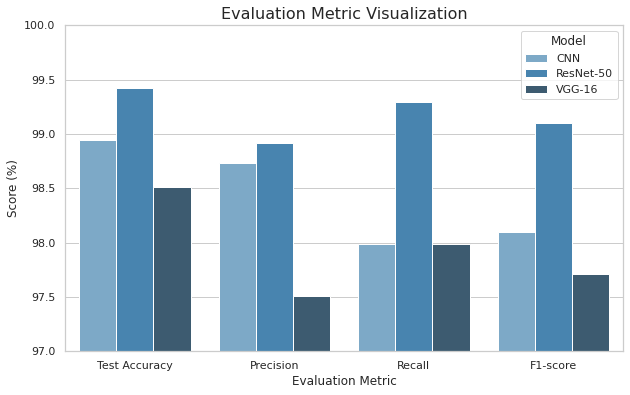

In [28]:
#Evaluation Metric Visualization
plot_data = {
    'Model': ['CNN', 'ResNet-50', 'VGG-16', 
              'CNN', 'ResNet-50', 'VGG-16',  
              'CNN', 'ResNet-50', 'VGG-16',  
              'CNN', 'ResNet-50', 'VGG-16'], 
    'Metric': ['Test Accuracy', 'Test Accuracy', 'Test Accuracy',  
               'Precision', 'Precision', 'Precision', 
               'Recall', 'Recall', 'Recall',  
               'F1-score', 'F1-score', 'F1-score'], 
    'Value': [98.94, 99.42, 98.51,  
              98.73, 98.92, 97.51,  
              97.99, 99.29, 97.99,  
              98.10, 99.10, 97.71]  
}


df = pd.DataFrame(plot_data)


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Value', hue='Model', data=df, palette="Blues_d")


ax.set_title('Evaluation Metric Visualization', fontsize=16)
ax.set_xlabel('Evaluation Metric', fontsize=12)
ax.set_ylabel('Score (%)', fontsize=12)
plt.ylim(97, 100)  

plt.show()


## 5 Results and Analysis

The performance of three deep learning models—CNN, ResNet-50, and VGG-16—was evaluated on the given dataset, and the results reveal some key insights. The CNN model achieved a test accuracy of 98.94%, with strong precision (0.9873) and recall (0.9799) values, demonstrating its ability to make accurate predictions and identify relevant instances effectively. Its F1-score of 0.9810 reflects a balanced performance, with minimal overfitting. The ResNet-50 model, however, outperformed the CNN in all aspects, achieving a remarkable test accuracy of 99.42%, alongside very high precision (0.9892) and recall (0.9929). This indicates that ResNet-50 not only made highly accurate predictions but also demonstrated superior generalization capabilities, as reflected in its F1-score of 0.9910. Lastly, the VGG-16 model showed a slightly lower test accuracy of 98.51%, along with lower precision (0.9751) and recall (0.9799) compared to both CNN and ResNet-50. The relatively lower precision indicates a higher rate of false positives, which contributed to its lower F1-score of 0.9771.

Overall, the results suggest that ResNet-50 is the best-performing model, achieving the highest test accuracy and demonstrating the best balance between precision and recall. While the CNN model also performed well, it was outperformed by ResNet-50 in terms of overall accuracy and robustness. The VGG-16 model, although still effective, showed slightly inferior results, making it less suitable for this particular task compared to the more advanced architectures like ResNet-50.

| Model       | Type          | Test Accuracy | Precision | Recall | F1-score |
|-------------|---------------|---------------|-----------|--------|----------|
| CNN         | Deep Learning | 0.9894        | 0.9873    | 0.9799 | 0.9810   |
| ResNet-50   | Deep Learning | 0.9942        | 0.9892    | 0.9929 | 0.9910   |
| VGG-16      | Deep Learning | 0.9851        | 0.9751    | 0.9799 | 0.9771   |


## 6 Discussion and Conclusion

The results of the deep learning models—CNN, ResNet-50, and VGG-16—demonstrate clear differences in performance for disaster tweet classification. ResNet-50 outperforms the other models with the highest accuracy (99.42%) and superior precision, recall, and F1-score. This indicates that its deeper architecture and residual connections help it capture complex patterns, making it highly effective for this task. CNN, with an accuracy of 98.94%, offers a good balance of performance, providing competitive precision and recall. While not as powerful as ResNet-50, it remains a reliable and efficient model, particularly in scenarios requiring faster training. VGG-16 shows the lowest performance among the three, with an accuracy of 98.51%. Its lower precision (0.9751) suggests more false positives, making it less reliable for this task compared to the CNN and ResNet-50 models.

In conclusion, ResNet-50 is the most effective model for disaster tweet classification, offering the best overall performance. CNN is a strong alternative, providing a balance of accuracy and efficiency, while VGG-16 may be better suited for other tasks, given its relatively lower performance here.

In the future, we will also introduce more advanced models, such as EfficientNet, Vision Transformer, or Swin Transformer, to achieve more accurate solutions for plant disease classification. Another possible solution is to build an ensemble model by combining the predictions of ResNet-50, CNN, and VGG-16, leveraging the strengths of each model to further improve classification performance.

## 7. Github Repository

https://github.com/Bob-cmu/Plant-Diseases

## 8. References

[1] https://www.kaggle.com/datasets/mohitsingh1804/plantvillage/data<br>
[2] https://www.kaggle.com/code/snowhite/fork-of-plant-village-all-classes-upto-98/notebook<br>
[3] https://github.com/ejroch/Plant-Diseases/tree/master<br>
[4] https://www.kaggle.com/code/mohitsingh1804/plants-disease-detection<br>
[5] https://arxiv.org/abs/1409.1556<br>
[6] https://arxiv.org/abs/1512.03385<br>
[7] https://arxiv.org/abs/1409.4842<br>
[8] https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html<br>
[9] https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html<br>
Note: While completing assignments, I might encounter some errors, which could be caused by a Python library that I am not familiar with. In such cases, I try to ask ChatGPT about the specific purpose and structural composition of the Python library.